### Reorder not allow

In [ ]:
import copy
import random
# reorder fail 21:53
C = [0 for i in range(32 * 4)]
C_idx = [[] for i in range(32 * 4)]
A = [random.randrange(-5, 5) for i in range(32 * 4)]
B = [random.randrange(-5, 5) for i in range(32 * 4)]
for xo in range(32):
    for xi in range(4):
        C[xo * 4 + xi] = A[xo * 4 + xi] + B[max(xo * 4 + xi - 1, 0)]
        C_idx[xo * 4 + xi]= [xo * 4 + xi, max(xo * 4 + xi - 1, 0)]

In [ ]:
C2 = [0 for i in range(32 * 4)]
C2_idx = [[] for i in range(32 * 4)]
for xi in range(4):
    for xo in range(32):
        C2[xo * 4 + xi] = A[xo * 4 + xi] + B[max(xo * 4 + xi - 1, 0)]
        C2_idx[xo * 4 + xi] = [xo * 4 + xi, max(xo * 4 + xi - 1, 0)]
   

In [ ]:
def diff_val(l1, l2):
    diff_list = []
    for idx, item_l1 in enumerate(l1):
        item_l2 = l2[idx]
        diff_list.append(item_l2 - item_l1)
    return diff_list

In [ ]:
def diff_idx(l1, l2):
    diff_list = []
    for idx, item_l1 in enumerate(l1):
        item_l2 = l2[idx]
        diff_list.append([item_l2[0] - item_l1[0], item_l2[1] - item_l1[1]])
    return diff_list

In [ ]:
# res = sum(diff(C, C2))
# res = diff_idx(C_idx, C2_idx)
# both are zero, wtf?

### Toy sample TVM

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 43.3 MB 39.0 MB/s 


In [ ]:
import numpy as np
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T

In [ ]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(A: T.Buffer[128, "float32"],
             B: T.Buffer[128, "float32"],
             C: T.Buffer[128, "float32"]):
        # extra annotations for the function
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i in range(128):
            with T.block("C"):
                # declare a data parallel iterator on spatial domain
                vi = T.axis.spatial(128, i)
                C[vi] = A[vi] + B[vi]

In [ ]:
sch = tvm.tir.Schedule(MyModule)

In [ ]:
block_c = sch.get_block("C")

In [ ]:
i, = sch.get_loops(block_c)

In [ ]:
from tvm import te

M = 1024
K = 1024
N = 1024

# The default tensor type in tvm
dtype = "float32"

target = "llvm"
dev = tvm.device(target, 0)

# Algorithm
k = te.reduce_axis((0, K), "k")
A = te.placeholder((M, K), name="A")
B = te.placeholder((K, N), name="B")
C = te.compute((M, N), lambda m, n: te.sum(A[m, k] * B[k, n], axis=k), name="C")

# Default schedule
func = te.create_prim_func([A, B, C])
func = func.with_attr("global_symbol", "main")
ir_module = IRModule({"main": func})
print(ir_module.script())


func = tvm.build(ir_module, target="llvm")  # The module for CPU backends.

a = tvm.nd.array(np.random.rand(M, K).astype(dtype), dev)
b = tvm.nd.array(np.random.rand(K, N).astype(dtype), dev)
c = tvm.nd.array(np.zeros((M, N), dtype=dtype), dev)
func(a, b, c)

evaluator = func.time_evaluator(func.entry_name, dev, number=1)
print("Baseline: %f" % evaluator(a, b, c).mean)

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def func(A: tir.Buffer[(1024, 1024), "float32"], B: tir.Buffer[(1024, 1024), "float32"], C: tir.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with tir.block("root")
        for i0, i1, i2 in tir.grid(1024, 1024, 1024):
            with tir.block("C"):
                m, n, k = tir.axis.remap("SSR", [i0, i1, i2])
                tir.reads(A[m, k], B[k, n])
                tir.writes(C[m, n])
                with tir.init():
                    C[m, n] = tir.float32(0)
                C[m, n] = C[m, n] + A[m, k] * B[k, n]
    
Baseline: 4.361387


In [ ]:
sch = tvm.tir.Schedule(ir_module)
type(sch)
block_c = sch.get_block("C")
# Get loops surrounding the block
(y, x, k) = sch.get_loops(block_c)
block_size = 32
yo, yi = sch.split(y, [None, block_size])
xo, xi = sch.split(x, [None, block_size])

sch.reorder(yo, xo, k, yi, xi)
print(sch.mod.script())

func = tvm.build(sch.mod, target="llvm")  # The module for CPU backends.

c = tvm.nd.array(np.zeros((M, N), dtype=dtype), dev)
func(a, b, c)

evaluator = func.time_evaluator(func.entry_name, dev, number=1)
print("after transformation: %f" % evaluator(a, b, c).mean)

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def func(A: tir.Buffer[(1024, 1024), "float32"], B: tir.Buffer[(1024, 1024), "float32"], C: tir.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with tir.block("root")
        for i0_0, i1_0, i2, i0_1, i1_1 in tir.grid(32, 32, 1024, 32, 32):
            with tir.block("C"):
                m = tir.axis.spatial(1024, i0_0 * 32 + i0_1)
                n = tir.axis.spatial(1024, i1_0 * 32 + i1_1)
                k = tir.axis.reduce(1024, i2)
                tir.reads(A[m, k], B[k, n])
                tir.writes(C[m, n])
                with tir.init():
                    C[m, n] = tir.float32(0)
                C[m, n] = C[m, n] + A[m, k] * B[k, n]
    
after transformation: 0.390557


In [ ]:
sch.parallel(yo)
print(sch.mod.script())
func = tvm.build(sch.mod, target="llvm")

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def func(A: tir.Buffer[(1024, 1024), "float32"], B: tir.Buffer[(1024, 1024), "float32"], C: tir.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with tir.block("root")
        for i0_0 in tir.parallel(32):
            for i1_0, i2, i0_1, i1_1 in tir.grid(32, 1024, 32, 32):
                with tir.block("C"):
                    m = tir.axis.spatial(1024, i0_0 * 32 + i0_1)
                    n = tir.axis.spatial(1024, i1_0 * 32 + i1_1)
                    k = tir.axis.reduce(1024, i2)
                    tir.reads(A[m, k], B[k, n])
                    tir.writes(C[m, n])
                    with tir.init():
                        C[m, n] = tir.float32(0)
                    C[m, n] = C[m, n] + A[m, k] * B[k, n]
    


**Course 4**
https://mlc.ai/zh/chapter_end_to_end/index.html

In [3]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [4]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



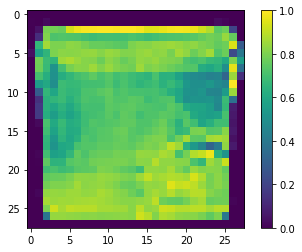

Class: Bag


In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

In [6]:
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-07-20 03:29:14--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-07-20 03:29:14--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.04s   

2022-07-20 03:29:14 (10.7 MB/s) - ‘fasionmnist_mlp_params.p

In [7]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [8]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[-20.587389 -55.69302  -10.325337 -24.640099 -16.863028 -17.343374
    9.167017 -55.49328   28.662739 -29.303942]]
[8]
NumPy-MLP Prediction: Bag


In [9]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: Bag


In [ ]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

call tir

In [ ]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

side effect free function
- program has side effect when it change the outside state (instead of only local state).

In [12]:
def lnumpy_call_tir(prim_func, inputs, shape, dtype):
    res = np.empty(shape, dtype=dtype)
    prim_func(*inputs, res)
    return res

In [13]:
def lnumpy_mlp_with_call_tir(data, w0, b0, w1, b1):
    lv0 = lnumpy_call_tir(lnumpy_linear0, (data, w0, b0), (1, 128), dtype="float32")
    lv1 = lnumpy_call_tir(lnumpy_relu0, (lv0, ), (1, 128), dtype="float32")
    out = lnumpy_call_tir(lnumpy_linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    return out

result = lnumpy_mlp_with_call_tir(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = np.argmax(result, axis=1)
print("Low-level Numpy with CallTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with CallTIR Prediction: Bag


 EP5 Automatic Program Optimization

In [ ]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [16]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(
        A: T.Buffer[(128, 128), "float32"],
        B: T.Buffer[(128, 128), "float32"],
        C: T.Buffer[(128, 128), "float32"],
    ):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

In [17]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

In [18]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 21.428 ms


In [ ]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [ ]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
IPython.display.HTML(code2html(sch.mod.script()))

In [ ]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

随即调度变换


In [ ]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch